In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, precision_recall_fscore_support

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader

from GlobalUtils import GlobalUtils

utils = GlobalUtils()


import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : True,
    'even_balance' : False
}
loadData = LoadData(**load_args)
train_ds = loadData.train
test_ds = loadData.test
handler = DataHandler(loadData)



If this is an error, please set use_true_test_set = False and reload the kernel
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded true test set, accompanied by a train set for preprocessing fitting.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (26527, 0.3371)  |  explosion: (25650, 0.3259)  |  noise: (26524, 0.337)  
Test ds:
earthquake: (698, 0.0396)  |  explosion: (8365, 0.4742)  |  noise: (8579, 0.4863)  


In [3]:
use_time_augmentor = True
scaler_name = "normalize"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_test, y_test, noiseAug = ramLoader.load_to_ram()

Initializing loading of the test set
Step 1: Fit augmentors and scalers on training data
Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 459.65904903411865 seconds. Total datapoints fitted: 78701.
Average time per datapoint: 0.005840574440402519


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Fit process of normalizer skipped as unecessary


Stage two loading training set, labels and normalize scaler: [--------------------------------------->] 100 %

Fitting noise augmentor: [--------------------------------------->] 100 %

Step 2: Load and transform the test set, using the previously fitted scaler and augmentors
Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 169.83698081970215 seconds. Total datapoints fitted: 17642.
Average time per datapoint: 0.009626855278296233


Stage one loading test set, timeAug: [------------------

In [4]:
from Classes.DataProcessing.RamGen import RamGen

In [5]:
# Path of the best performing model on Noise vs Not-Noise
save_dir_3n = '/media/tord/T7/Thesis_ssd/SavedModels/CNN'
model_name_3n = 'CNN_3N_final'
model_3n_path = f'{save_dir_3n}/{model_name_3n}'
# This model is trained with batch_size of 256
# Batch size will be 1 for predictions
print(model_3n_path)
model_3n = helper.load_model(model_3n_path)



# Path of the best performing model on Explosion vs Earthquake
save_dir_ee = '/media/tord/T7/Thesis_ssd/SavedModels/CNN'
model_name_ee = 'CNN_EE_final'
model_ee_path = f'{save_dir_ee}/{model_name_ee}'
# This model is trained with batch_size of 256
# Batch size will be 1 for predictions
model_ee = helper.load_model(model_ee_path)


/media/tord/T7/Thesis_ssd/SavedModels/CNN/CNN_3N_final


In [30]:
import time

def predict_final_model(loadData, model_3n, model_ee, test_traces, test_labels, noiseAug, num_channels_3n, num_channels_ee):
    # This function assumes data to be preprocessed with normalize scaler
    
    noise_not_noise_dict = loadData.noise_not_noise_dict()
    start = time.time()
    predictions_3n = helper.predict_RamGenerator(model_3n, test_traces, test_labels, 1, True, noiseAug, None, num_channels_3n, final_eval = True)
    print(f"Completed 3N predictions after f{round(time.time()-start)} seconds. Amount of predictions: {len(test_labels)}")
    print(f"Average time per datapoint: {(time.time() - start)/len(test_labels)}")
    rounded_3n_predictions = np.rint(predictions_3n)
    
    
    earth_explo_dict = loadData.earth_explo_dict()
    not_noise_traces, not_noise_labels = get_not_noise_traces_labels(predictions_3n, test_traces, test_labels, noise_not_noise_dict)
    ee_start = time.time()
    predictions_ee = helper.predict_RamGenerator(model_ee, not_noise_traces, not_noise_labels, 1, True, noiseAug, None, num_channels_ee, final_eval = True)
    print(f"Completed 3N predictions after f{round(time.time()-ee_start)} seconds. Amount of predictions: {len(test_labels)}")
    print(f"Average time per datapoint: {(time.time() - ee_start)/len(test_labels)}")
    rounded_ee_predictions = np.rint(predictions_ee)
    print(rounded_ee_predictions)
    
    # Converting the 3N predictions into string
    dict_3n = {'noise' : 0, 'not_noise' : 1}
    converted_3n_predictions = convert_predictions(rounded_3n_predictions, dict_3n)
    print(converted_3n_predictions)
    # We now have a list of ["noise", "not-noise"...]
    # We want to take the not-noise elements and convert them into their final predictions.
    # We can do this by using a list of indexes of the not noise elements, and replace them by their true final predictions.
    not_noise_indexes = get_not_noise_indexes(rounded_3n_predictions, noise_not_noise_dict)
    

    end = time.time()
    print(f"Prediction of {len(test_labels)} complete. Process took {round(end-start)} seconds")
    print(f"Average time per datapoint: {(end-start)/len(test_labels)}")
    converted_predictions = convert_ee_predictions(rounded_ee_predictions, earth_explo_dict, converted_3n_predictions, not_noise_indexes)
    return converted_predictions, predictions_3n, predictions_ee, not_noise_indexes
    
def get_not_noise_indexes(rounded_predictions, noise_not_noise_dict):
    not_noise_indexes = np.where(rounded_predictions == 1)[0]
    return not_noise_indexes
    
def get_not_noise_traces_labels(predictions, test_traces, test_labels, noise_not_noise_dict):
    rounded_predictions = np.rint(predictions)
    not_noise_indexes = get_not_noise_indexes(rounded_predictions, noise_not_noise_dict)
    not_noise_traces = test_traces[not_noise_indexes][:]
    not_noise_labels = test_labels[not_noise_indexes]
    return not_noise_traces, not_noise_labels

def convert_ee_predictions(rounded_predictions, label_dict, converted_3n_predictions, not_noise_indexes):
    final_predictions = converted_3n_predictions.copy()
    converted_ee_predictions = convert_predictions(rounded_predictions, label_dict)
    for idx, nn_index in enumerate(not_noise_indexes):
        final_predictions[nn_index] = converted_ee_predictions[idx]
    return final_predictions
    
def convert_predictions(rounded_predictions, label_dict):
    transformed_predictions = np.empty((rounded_predictions.shape), dtype=object)
    # Assumes that the dictionary is sorted by ascending values. Also that the key, value pair is unique
    keys = list(label_dict.keys())
    for idx, pred in enumerate(rounded_predictions):
        transformed_predictions[idx] =  keys[int(pred[0])]
    return transformed_predictions

def transform_true_labels(true_labels, final_dict):
    output = np.empty((len(true_labels)))
    for idx, lab in enumerate(true_labels):
        output[idx] = np.where(lab == 1)[0]
    return output

import matplotlib.pyplot as plt
def plot_confusion_matrix(conf, label_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    labels = list(label_dict.keys())
    for x in range(len(labels)):
        for y in range(len(labels)):
            ax.annotate(str(np.array(conf[x,y]).ravel()[0]), xy = (y, x), ha = 'center', va = 'center')
    print(labels)
    offset = 0.5
    width = height = len(labels)
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)
    plt.title(f'Confusion matrix of the final classifier on the test set')
    #ax.set_xticklabels([''] + labels)
    #ax.set_yticklabels([''] + labels)
    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset, color  = "black")
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset, color = "black")
    plt.xticks(range(width), labels)
    plt.yticks(range(height), labels)
    ax.invert_yaxis()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_all_unidentified_by_type(type_int, predictions, y_test):
    index_list = []
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    final_true = transform_true_labels(y_test, final_dict)
    for i in range(len(final_true)):
        if final_true[i] == type_int and final_true[i] != final_preds[i]:
            index_list.append(i)
    return index_list

def get_distance_distribution(ds):
    total = len(ds)
    all_dist = []
    for idx, path_label in enumerate(ds):
        path, label, _ = path_label
        dist = np.rint(handler.path_to_trace(path)[1].get('dist_to_arces'))
        all_dist.append(dist)
    return all_dist

    
def get_magnitude_distribution(ds):
    total = len(ds)
    all_mag = []
    for idx, path_label in enumerate(ds):
        path, label, _ = path_label
        #mag = handler.path_to_trace(path)[1].get('magnitudes')[0]['mag']
        mag = get_local_magnitude(path)
        all_mag.append(mag)
    return all_mag

def get_local_magnitude(path):
    mags = handler.path_to_trace(path)[1].get("magnitudes")
    if len(mags) == 1:
        mags = mags[0]
        mag = mags["mag"]
    else:
        take_second_best = False
        for d in mags:
            if d.get("magnitude_type").lower() == "ml":
                if d["mag"] >= 0:
                    mag = d["mag"]
                else:
                    take_second_best = True
        if take_second_best:
            for d in mags:
                if d["mag"] >= 0:
                    mag = d["mag"]
                    break
        if mag is None:
            raise Exception(f"Local magnitude of {path} is not found: {mags}")
    return mag

def get_msrdr_distribution(ds):
    total = len(ds)
    all_msrdr = []
    for idx, path_label in enumerate(ds):
        path, label, _ = path_label
        msrdr = handler.path_to_trace(path)[1].get('magnitude_sqrtdist_ratio')
        all_msrdr.append(msrdr)
    return all_msrdr    


def get_bins_count_pdf_cdf(dist, nr_bins, minimum, maximum):
    print(f"Max dist: {max(dist)}")
    print(f"Min dist: {min(dist)}")
    count, bins_count = np.histogram(dist, bins = nr_bins, range = (minimum, maximum))
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count, count, pdf, cdf

def plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    plt.bar(bins_count_o[1:], counts_o, width=width, color="blue", label=f"All {key_list[type_int]}s")
    plt.bar(bins_count_u[1:], counts_u, width=width, color="red", label=f"Correctly identified {key_list[type_int]}s")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()

    
def broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, low_max, high_max, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.01)
    # Plotting data on both axis:
    ax1.bar(bins_count_o[1:], counts_o, width = width, color = "blue", label=f"All {key_list[type_int]}s")
    ax2.bar(bins_count_o[1:], counts_o, width = width, color = "blue", label=f"All {key_list[type_int]}s")
    ax1.bar(bins_count_u[1:], counts_u, width = width, color = "red", label=f"Correctly identified {key_list[type_int]}s")
    ax2.bar(bins_count_u[1:], counts_u, width = width, color = "red", label=f"Correctly identified {key_list[type_int]}s")
    
    
    # Setting cutoff:
    ax1.set_ylim(low_max, high_max)
    ax2.set_ylim(0, low_max)
    
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.tick_bottom()
    ax2.yaxis.tick_left()
    ax1.yaxis.tick_left()
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(bottom=False)
    
    # Slant of cutoff markers
    d = 0.5
    kwargs = dict(marker = [(-1, -d),(1,d)], markersize = 12, 
                  linestyle ="none", color = 'k', mec = 'k', mew = 1, clip_on = False)
    ax1.plot([0,1], [0,0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0,1], [1,1], transform=ax2.transAxes, **kwargs)
    plt.xlabel(xlabel)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
    fig.text(0.30, 0.9, title, va = 'center')
    ax1.legend(loc = 'best')
    plt.show()
    
          
def plot_distances_unid(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_all_unidentified_by_type(type_int, predictions, y_test)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    counts_u = counts_o - counts_u
    
    if type_int == 1:
        low_max = 40
        high_max = 3200
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")
    else:
    
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

    
def plot_magnitude_unid(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_all_unidentified_by_type(type_int, predictions, y_test)
    unid = test_ds[unid]
    unid_dist = get_magnitude_distribution(unid)
    all_dist = get_magnitude_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 6)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 6)
    counts_u = counts_o - counts_u
    if type_int == 1:
        low_max = 50
        high_max = 2500
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 0.1, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} magntidues in the test set", "Magnitude", "Frequency")
    if type_int == 2:
        low_max = 10
        high_max = 150
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 0.1, type_int, f"Distribution of {key_list[type_int]} magntidues in the test set", "Magnitude", "Frequency")
    

def plot_msrdr_unid(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_all_unidentified_by_type(type_int, predictions, y_test)
    unid = test_ds[unid]
    unid_dist = get_msrdr_distribution(unid)
    all_dist = get_msrdr_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 60

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 0.8)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 0.8)
    counts_u = counts_o - counts_u
    if type_int == 1:
        low_max = 20
        high_max = 3000
    if type_int == 2:
        low_max = 10
        high_max = 150
    
    broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 0.01, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} MSRDR in the test set", "MSRDR", "Frequency")

    
    
from scipy.stats import linregress

def plot_distances_noise(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    
    if type_int == 1:
        low_max = 40
        high_max = 3200
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")
    else:
    
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

def plot_distances_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Distance distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Distance"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
        #plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

        
def plot_magnitude_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_magnitude_distribution(unid)
    all_dist = get_magnitude_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 6)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 6)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Magnitude distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Magnitude"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 0.1, type_int, title, xlabel, ylabel)
    
def plot_distance_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Distance distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Distance"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 50, type_int,0, title, xlabel, ylabel)
    
def plot_magnitude_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_magnitude_distribution(unid)
    all_dist = get_magnitude_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 6)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 6)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Magnitude distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Magnitude"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 0.1, type_int,0, title, xlabel, ylabel)

    
def plot_msrdr_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_msrdr_distribution(unid)
    all_dist = get_msrdr_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 60

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 0.8)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 0.8)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"MSRDR distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "MSRDR"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 0.01, type_int, 0, title, xlabel, ylabel)

    
    
def plot_msrdr_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_msrdr_distribution(unid)
    all_dist = get_msrdr_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 0.8)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 0.8)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"MSRDR distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "MSRDR"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 0.01, type_int, 0, title, xlabel, ylabel)


def plot_adjusted(pdf, bins_count, counts, width, type_int, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    plt.bar(bins_count[1:], counts, width=width, color="red", label=f"E{key_list[type_int][1:]}s predicted to be noise, adjusted for population")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()

def plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts_a, width, type_int, type_int_2, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.1)
    ax1.bar(bins_count_o[1:], counts_o, width=width, color="blue", label=f"All {key_list[type_int]}s")
    ax1.bar(bins_count_u[1:], counts_u, width=width, color="red", label=f"E{key_list[type_int][1:]}s predicted \nto be {key_list[type_int_2]}")
    
    slope, intercept, r_value, p_value, std_err  = linregress(bins_count_u[1:], counts_a)
    
    ax2.plot(bins_count_u[1:], slope*bins_count_u[1:]+intercept, color = "red", label = f"Linear regression line. P-value: {round(p_value, 2)}\n R-value: {round(r_value, 2)}")
    print("Intercept: ", intercept)
    print("Coef: ", slope)
    print("P-value: ", p_value)
    
    #coef = np.polyfit(bins_count_u[1:], counts_a,1)
    #poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    #plt.plot(bins_count_u[1:], counts_a, 'yo', bins_count_u[1:], poly1d_fn(bins_count_u[1:]), '--k', color = "black")
    #plt.plot(bins_count_u[1:], counts_a, 'yo', bins_count_u[1:], poly1d_fn(bins_count_u[1:]), '--k', color = "black")
    ax2.bar(bins_count_u[1:], counts_a, width=width, color="black", label=f"E{key_list[type_int][1:]}s predicted to be {key_list[type_int_2]},\n adjusted for population")
    plt.ylim(bottom = 0)
    
    fig.text(0.45, 0.08, xlabel, va='center')
    fig.text(0.04, 0.5, "Frequency", va='center', rotation='vertical')
    fig.text(0.48, 0.5, "Proportion", va='center', rotation = 'vertical')
    fig.text(0.35, 0.9, title, va = 'center')
    ax1.legend()
    ax2.legend()
    plt.show()

def get_class_incorrectly_predicted_noise(test_pred, y_true, type_int):
    index_list = []
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    print(final_preds)
    final_true = transform_true_labels(y_test, final_dict)
    for i in range(len(test_pred)):
        if final_preds[i] == 0 and final_true[i] == type_int:
            index_list.append(i)
    return index_list

def get_class_incorrectly_predicted_not_noise(test_pred, y_true, type_int):
    index_list = []
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    print(final_preds)
    final_true = transform_true_labels(y_test, final_dict)
    for i in range(len(test_pred)):
        if final_preds[i] == type_int and final_true[i] == 0:
            index_list.append(i)
    return index_list

def adjust_by_pop(counts_o, counts_u):
    new_counts = []
    for i in range(len(counts_o)):
        if counts_u[i] == 0:
            new_counts.append(0)
        else:
            new_counts.append(counts_u[i]/counts_o[i])
    return new_counts
    
def plot_all_plots(predictions, y_test, test_ds):
    print("Plotting errors")
    print("Distances:")
    plot_distances_unid(predictions, y_test, test_ds, 1)
    plot_distances_unid(predictions, y_test, test_ds, 2)
    print("Magnitudes:")
    plot_magnitude_unid(predictions, y_test, test_ds, 1)
    plot_magnitude_unid(predictions, y_test, test_ds, 2)
    print("MSRDR:")
    plot_msrdr_unid(predictions, y_test, test_ds, 1)
    plot_msrdr_unid(predictions, y_test, test_ds, 2)
    print("Finished")
    print("Plotting events incorrectly labeled noise:")
    print("Distances:")
    plot_distance_noise_both(test_pred, y_test, test_ds, 1)
    plot_distance_noise_both(test_pred, y_test, test_ds, 2)
    print("Magnitudes:")
    plot_magnitude_noise_both(test_pred, y_test, test_ds, 1)
    plot_magnitude_noise_both(test_pred, y_test, test_ds, 2)
    print("MSRDR:")
    plot_msrdr_noise_both(test_pred, y_test, test_ds, 1)
    plot_msrdr_noise_both(test_pred, y_test, test_ds, 2)
    
    
    
    
    

In [24]:
def evaluate_full_pipeline(test_pred, test_traces, test_labels, test_ds):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    # We now have the predictions in their string form and (assumed) in the correct ordering
    # Let us now convert the final predictions and true labels into one-hot encoding
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    final_true = transform_true_labels(test_labels, final_dict)
    assert len(final_preds) == len(final_true), f"preds len {len(final_preds)}, true len {len(final_true)}"
    # Should be able to attempt to print a confusion matrix now
    conf=tf.math.confusion_matrix(final_true, final_preds, num_classes = 3)
    precision, recall, fscore, _ = precision_recall_fscore_support(final_true, final_preds, beta = 2, average = "macro", zero_division = 0.0)
    report = classification_report(final_true, final_preds, target_names = final_dict)
    plot_all_plots(test_pred, test_labels, test_ds)
    return conf, report, precision, recall, fscore
    

Plotting errors
Distances:
Max dist: 1852.0
Min dist: 86.0
Max dist: 1965.0
Min dist: 86.0


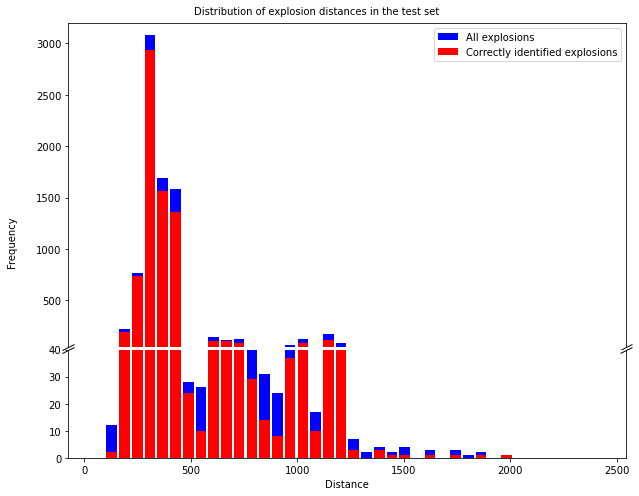

Max dist: 2394.0
Min dist: 137.0
Max dist: 2394.0
Min dist: 11.0


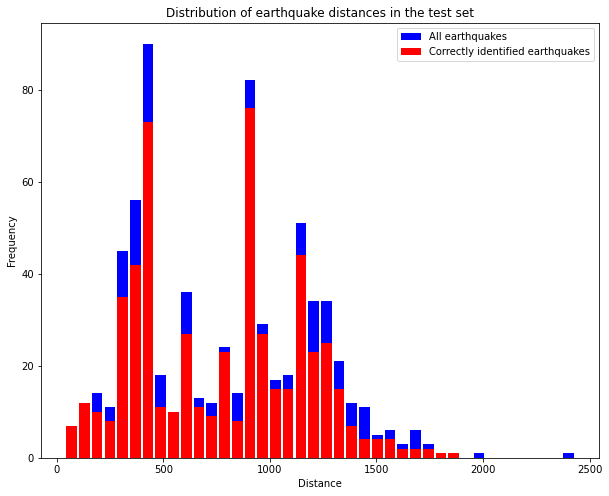

Magnitudes:
Max dist: 4.3
Min dist: 0.4
Max dist: 4.3
Min dist: 0.3


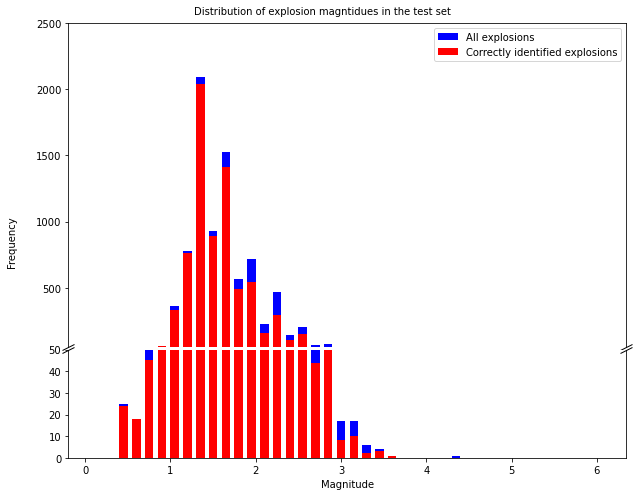

Max dist: 4.342
Min dist: 1.0
Max dist: 5.3
Min dist: 0.7


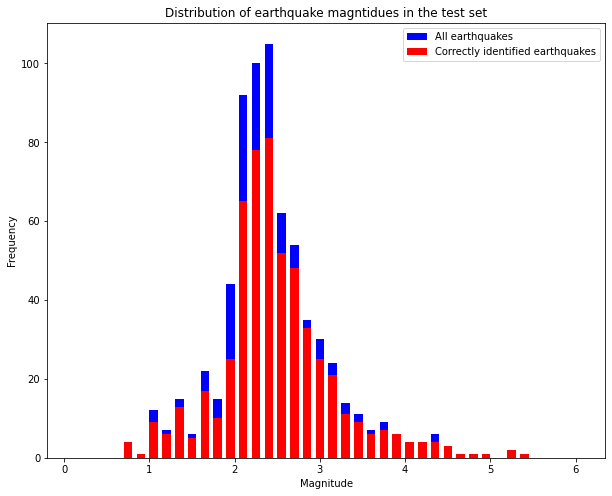

MSRDR:
Max dist: 0.2204338987563581
Min dist: 0.060004438309835983
Max dist: 0.248623046072668
Min dist: 0.06000339438365045


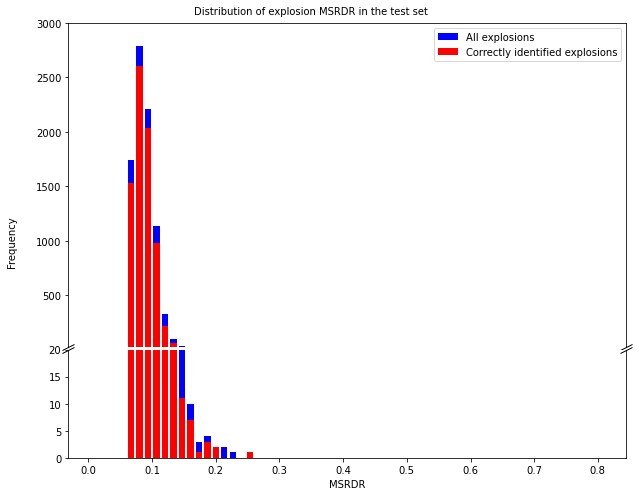

Max dist: 0.22025937986007593
Min dist: 0.06073591348988495
Max dist: 0.789717329282861
Min dist: 0.06039273726920308


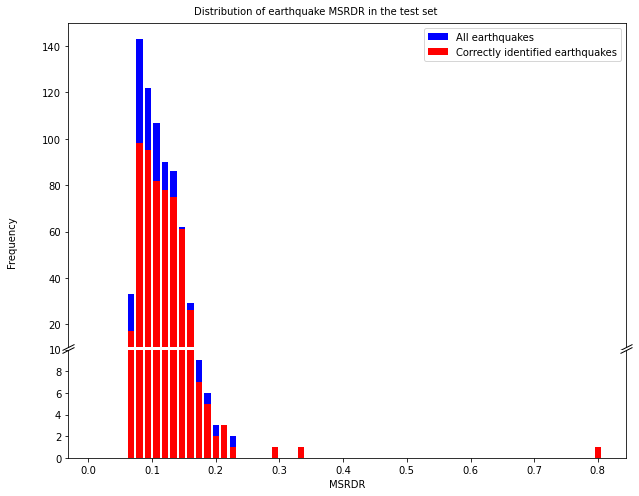

Finished
Plotting events incorrectly labeled noise:
Distances:
[0 0 0 ..., 1 1 0]
Max dist: 1852.0
Min dist: 176.0
Max dist: 1965.0
Min dist: 86.0
Intercept:  0.100924789365
Coef:  1.21747828584e-05
P-value:  0.803107694741


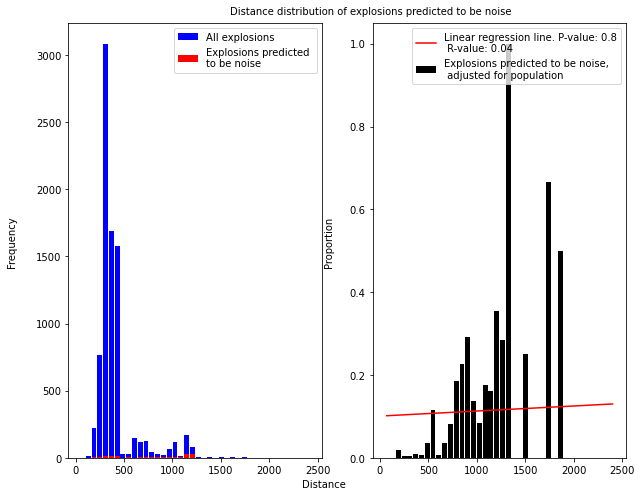

[0 0 0 ..., 1 1 0]
Max dist: 2394.0
Min dist: 139.0
Max dist: 2394.0
Min dist: 11.0
Intercept:  0.00726640616643
Coef:  8.49530280906e-05
P-value:  0.0697704501882


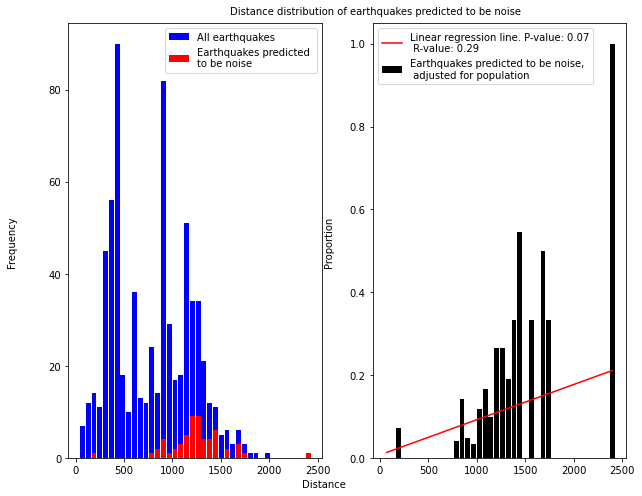

Magnitudes:
[0 0 0 ..., 1 1 0]
Max dist: 4.3
Min dist: 0.4
Max dist: 4.3
Min dist: 0.3
Intercept:  0.0226619001967
Coef:  0.00604433063018
P-value:  0.681749040669


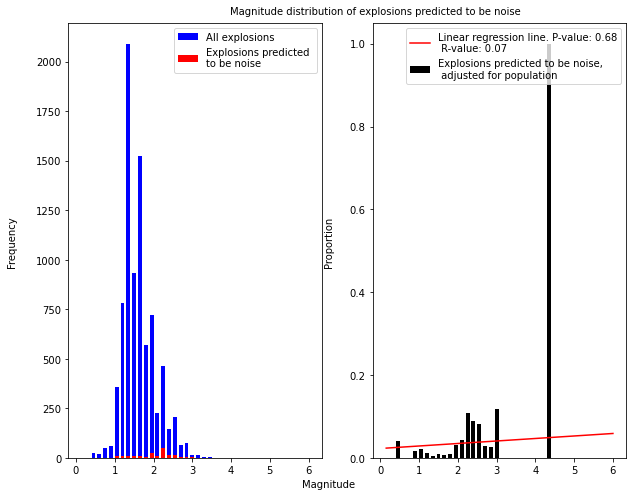

[0 0 0 ..., 1 1 0]
Max dist: 4.302
Min dist: 1.72
Max dist: 5.3
Min dist: 0.7
Intercept:  0.0429245895915
Coef:  -0.00188204358503
P-value:  0.722373177151


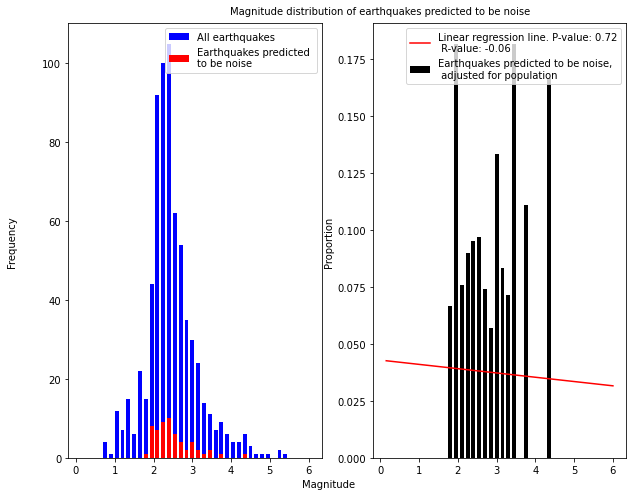

MSRDR:
[0 0 0 ..., 1 1 0]
Max dist: 0.14095092201657328
Min dist: 0.060004438309835983
Max dist: 0.248623046072668
Min dist: 0.06000339438365045
Intercept:  0.00747566246562
Coef:  -0.0129317092312
P-value:  0.0071472403714


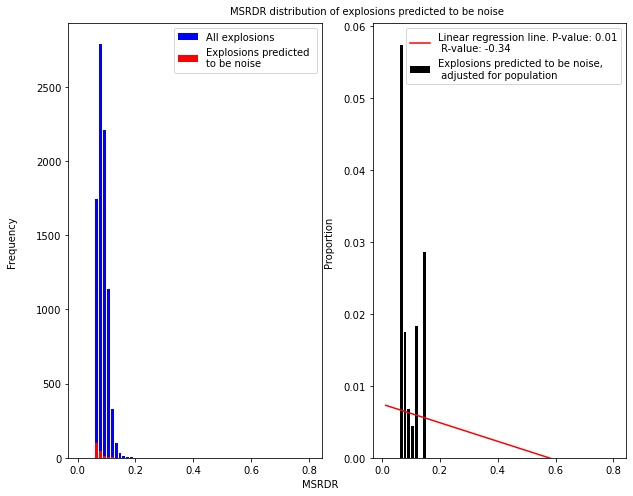

[0 0 0 ..., 1 1 0]
Max dist: 0.22025937986007593
Min dist: 0.06073591348988495
Max dist: 0.789717329282861
Min dist: 0.06039273726920308
Intercept:  0.0585998102035
Coef:  -0.0963094895872
P-value:  0.0288425241499


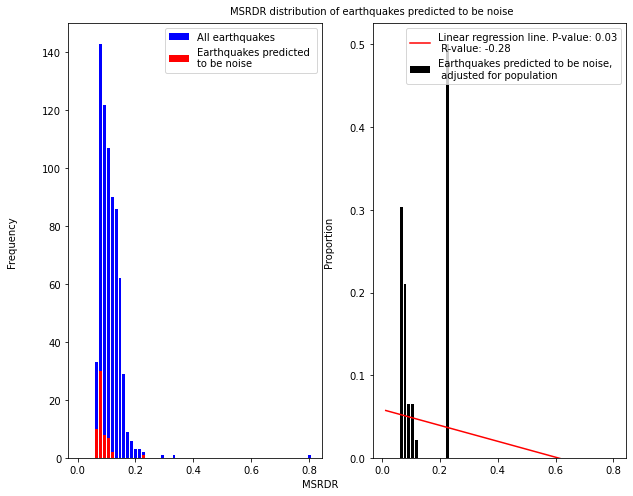

tf.Tensor(
[[8407   65  107]
 [ 176 7452  737]
 [  58   87  553]], shape=(3, 3), dtype=int32)
              precision    recall  f1-score   support

       noise       0.97      0.98      0.98      8579
   explosion       0.98      0.89      0.93      8365
  earthquake       0.40      0.79      0.53       698

    accuracy                           0.93     17642
   macro avg       0.78      0.89      0.81     17642
weighted avg       0.95      0.93      0.94     17642

['noise', 'explosion', 'earthquake']


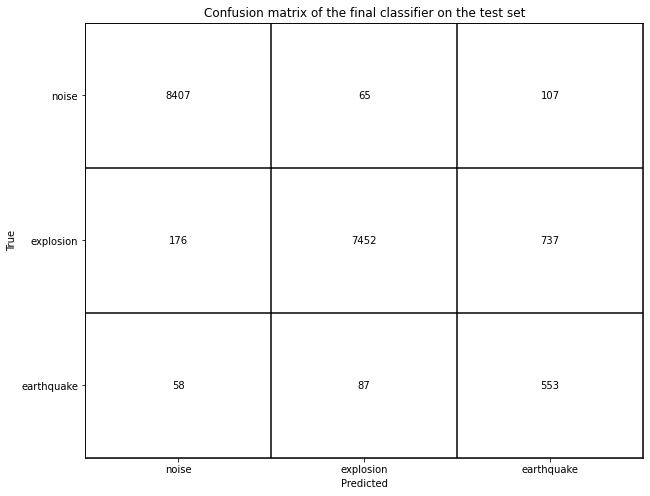

In [31]:
#test_pred, pred_3n, pred_ee, not_noise_indexes = predict_final_model(loadData, model_3n, model_ee, x_test, y_test, noiseAug, 3, 3)

conf, report, precision, recall, fscore  = evaluate_full_pipeline(test_pred, x_test, y_test, test_ds)

print(conf)
print(report)
plot_confusion_matrix(conf,{"noise" : 0, "explosion" : 1, "earthquake" : 2})

In [9]:
earth_noise = get_class_incorrectly_predicted_not_noise(test_pred, y_test, 2)

[0 0 0 ..., 1 1 0]


In [6]:
print(len(earth_noise), earth_noise)

NameError: name 'earth_noise' is not defined

In [12]:
import json
def make_empty_dict(ds):
    out = {}
    for i in range(len(ds)):
        out[ds[i][0]] = {"3n_pred" : np.nan,
                          "ee_pred" : np.nan,
                          "test_ds_index" : np.nan,
                          "not_noise_index" : np.nan,
                          "magnitude" : np.nan,
                          "magnitude_type" : np.nan,
                          "distance" : np.nan,
                          "msrdr" : np.nan,
                          "true_label" : ds[i][1],
                          "predicted_label" : ""}
    return out

def map_preds(pred_3n, pred_ee, ds, not_noise_indexes):
    di = make_empty_dict(ds)
    # First enter all 3n predictions
    ee_index_tracker = 0
    for i in range(len(ds)):
        path = ds[i][0]
        true_lab = ds[i][1]
        di[path]["3n_pred"] = pred_3n[i][0]
        di[path]["test_ds_index"] = i
        if true_lab != "noise":
            di[path]["distance"] = np.rint(handler.path_to_trace(path)[1].get('dist_to_arces'))
            di[path]["msrdr"] = handler.path_to_trace(path)[1].get('magnitude_sqrtdist_ratio')
            mags = handler.path_to_trace(path)[1].get("magnitudes")
            if len(mags) == 1:
                mags = mags[0]
                mag = mags["mag"]
                di[path]["magnitude_type"] = mags.get("magnitude_type")
            else:
                take_second_best = False
                for d in mags:
                    if d.get("magnitude_type").lower() == "ml":
                        if d["mag"] >= 0:
                            mag = d["mag"]
                            di[path]["magnitude_type"] = "ML"
                        else:
                            take_second_best = True
                if take_second_best:
                    for d in mags:
                        if d["mag"] >= 0:
                            mag = d["mag"]
                            di[path]["magnitude_type"] = d.get("magnitude_type")
                            break
                if mag is None:
                    raise Exception(f"Local magnitude of {path} is not found: {mags}")
            di[path]["magnitude"] = mag
        if pred_3n[i] > 0.5:
            di[ds[i][0]]["ee_pred"] = pred_ee[ee_index_tracker][0]
            di[ds[i][0]]["not_noise_index"] = ee_index_tracker
            if pred_ee[ee_index_tracker] > 0.5:
                di[ds[i][0]]["predicted_label"] = "earthquake"
            else:
                di[ds[i][0]]["predicted_label"] = "explosion"
            ee_index_tracker += 1
        else:
            di[ds[i][0]]["predicted_label"] = "noise"
    return di


def get_noise_predicted_earthquake(mapped_preds, test_ds):
    new_di = {}
    noise_ds = test_ds[test_ds[:,1] == "noise"]
    for i in range(len(noise_ds)):
        if mapped_preds[noise_ds[i][0]]["predicted_label"] == "earthquake":
            new_di[noise_ds[i][0]] = mapped_preds[noise_ds[i][0]]
    return new_di
            
    
def get_class1_predicted_class2(mapped_preds, test_ds, class1, class2):
    label_dict  = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    new_di = {}
    class1_str = list(label_dict.keys())[class1]
    class2_str = list(label_dict.keys())[class2]
    class1_ds = test_ds[test_ds[:,1] == class1_str]
    for i in range(len(class1_ds)):
        if mapped_preds[class1_ds[i][0]]["predicted_label"] == class2_str:
            new_di[class1_ds[i][0]] = mapped_preds[class1_ds[i][0]]
    return new_di

          


def get_class(mapped_preds, test_ds, class1):
    label_dict  = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    new_di = {}
    class1_str = list(label_dict.keys())[class1]
    class_ds = test_ds[test_ds[:,1] == class1_str]
    for i in range(len(class_ds)):
        new_di[class_ds[i][0]] = mapped_preds[class_ds[i][0]]
    return new_di
    
def get_bins_count_pdf_cdf(dist, nr_bins, min_dist, max_dist):
    count, bins_count = np.histogram(dist, bins = nr_bins, range = (min_dist, max_dist))
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count, count, pdf, cdf

def plot_adjusted(pdf, pdf_2, bins_count, bins_count_2, counts, counts_2, width, type_int, type_int_2, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    plt.bar(bins_count[1:], counts, width=width, color="black", label=f"E{key_list[type_int][1:]}s predicted to be earthquake")
    plt.bar(bins_count_2[1:], counts_2, width = width, color = "red", label = f"E{key_list[type_int_2][1:]}s predicted to be explosion")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()

In [13]:
def get_distribution_of_mapped_preds(mapped_preds, metric):
    path_list = list(mapped_preds.keys())
    distribution = []
    for path in path_list:
        distribution.append(mapped_preds[path][metric])
    return distribution

In [14]:
mapped_preds = map_preds(pred_3n, pred_ee, test_ds, not_noise_indexes)

In [146]:
earth_pred_explo = get_class1_predicted_class2(mapped_preds, test_ds, 2, 1)
explo_pred_earth = get_class1_predicted_class2(mapped_preds, test_ds, 1, 2)

In [150]:
explo_pred_earth

{'/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/1994-04-06T09.00.31.967000Z.h5': {'3n_pred': 0.99999356,
  'ee_pred': 0.95632213,
  'test_ds_index': 24,
  'not_noise_index': 10,
  'magnitude': 2.2,
  'magnitude_type': 'MA',
  'true_label': 'explosion',
  'predicted_label': 'earthquake'},
 '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2018-02-21T00.16.44.178000Z.h5': {'3n_pred': 0.99998391,
  'ee_pred': 0.50149918,
  'test_ds_index': 50,
  'not_noise_index': 23,
  'magnitude': 1.5,
  'magnitude_type': 'ML',
  'true_label': 'explosion',
  'predicted_label': 'earthquake'},
 '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2012-11-06T10.17.32.531000Z.h5': {'3n_pred': 0.97141504,
  'ee_pred': 0.50132978,
  'test_ds_index': 90,
  'not_noise_index': 39,
  'magnitude': 1.5,
  'magnitude_type': 'ML',
  'true_label': 'explosion',
  'predicted_label': 'earthquake'},
 '/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-08-20T10.23.17.962000Z.h5': {'3n_pred': 0.99971968,


In [148]:
earth_pred_explo_mag = get_distribution_of_mapped_preds(earth_pred_explo, "magnitude")
explo_pred_earth_mag = get_distribution_of_mapped_preds(explo_pred_earth, "magnitude")

In [149]:
er_pred_ex_bins_count, er_pred_ex_count, er_pred_ex_pdf, er_pred_ex_cdf = get_bins_count_pdf_cdf(earth_pred_explo_mag, 40)
ex_pred_er_bins_count, ex_pred_er_count, ex_pred_er_pdf, ex_pred_er_cdf = get_bins_count_pdf_cdf(explo_pred_earth_mag, 40)

Max dist: 4.342
Min dist: 1.0
Max dist: 3.4
Min dist: 0.7


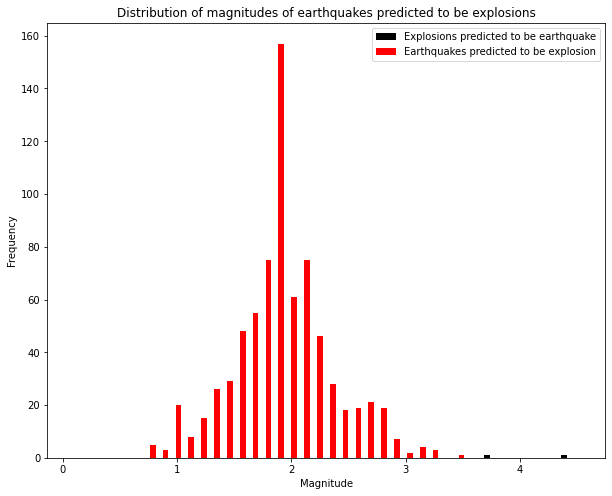

In [205]:
plot_adjusted(er_pred_ex_pdf, ex_pred_er_pdf, er_pred_ex_bins_count, ex_pred_er_bins_count, er_pred_ex_count, ex_pred_er_count, 0.05,  1, 2, "Distribution of magnitudes of earthquakes predicted to be explosions", "Magnitude" , "Frequency")


In [17]:
def plot_error_both(pred_3n, pred_ee, test_ds, not_noise_indexes, metric, type_int, type_int_2, width):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    mapped_preds = map_preds(pred_3n, pred_ee, test_ds, not_noise_indexes)
    e_p_e = get_class1_predicted_class2(mapped_preds, test_ds, type_int, type_int_2)
    e_pred_e_dist = get_distribution_of_mapped_preds(e_p_e, metric)
    
    mapped_class = get_class(mapped_preds, test_ds, type_int)
    all_dist = get_distribution_of_mapped_preds(mapped_class, metric)
    nr_bins = 50
    min_dist = min(all_dist)
    max_dist = max(all_dist)
    print(min_dist, max_dist)
    
    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(e_pred_e_dist, nr_bins, min_dist, max_dist)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, min_dist, max_dist)

    counts = adjust_by_pop(counts_o, counts_u)
    title = f"{metric.capitalize()} distribution of {key_list[type_int]}s predicted to be {key_list[type_int_2]}"
    xlabel = f"{metric.capitalize()}"
    ylabel = "Frequency"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, width, type_int, type_int_2, title, xlabel, ylabel)

def get_unidentified_predictions(mapped_preds, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    class_str = list(final_dict.keys())[type_int]
    type_ds = test_ds[test_ds[:,1] == class_str]
    out_dict = {}
    for path in type_ds[:,0]:
        if mapped_preds[path]["true_label"] != mapped_preds[path]["predicted_label"]:
            out_dict[path] = mapped_preds[path]
    return out_dict
    
    
def plot_metric_single(mapped_preds, test_ds, metric, type_int, type_int_2, width, broken = False):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    t_p_t = get_class1_predicted_class2(mapped_preds, test_ds, type_int, type_int_2)
    t_p_t_distribution = get_distribution_of_mapped_preds(t_p_t, metric)
    
    mapped_type1 = get_class(mapped_preds, test_ds, type_int)
    all_dist = get_distribution_of_mapped_preds(mapped_type1, metric)
    nr_bins = 40
    
    min_dist = min(all_dist)
    max_dist = max(all_dist)

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(t_p_t_distribution, nr_bins, min_dist, max_dist)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, min_dist, max_dist)
    counts_u = counts_o - counts_u
    
    if broken:
        low_max = 40
        high_max = 3200
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")
    else:
    
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

def plot_unid_single(mapped_preds, test_ds, metric, type_int, type_int_2, width, broken = False):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_unidentified_predictions(mapped_preds, test_ds, type_int)
    unid_distribution = get_distribution_of_mapped_preds(unid, metric)
    
    mapped_type1 = get_class(mapped_preds, test_ds, type_int)
    all_dist = get_distribution_of_mapped_preds(mapped_type1, metric)
    nr_bins = 40
    
    min_dist = min(all_dist)
    max_dist = max(all_dist)

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_distribution, nr_bins, min_dist, max_dist)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, min_dist, max_dist)
    counts_u = counts_o - counts_u
    
    if broken:
        low_max = 40
        high_max = 3200
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")
    else:
    
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, width, type_int, f"Distribution of {key_list[type_int]} {metric}s in the test set", metric.capitalize(), "Frequency")

    
    
    
    

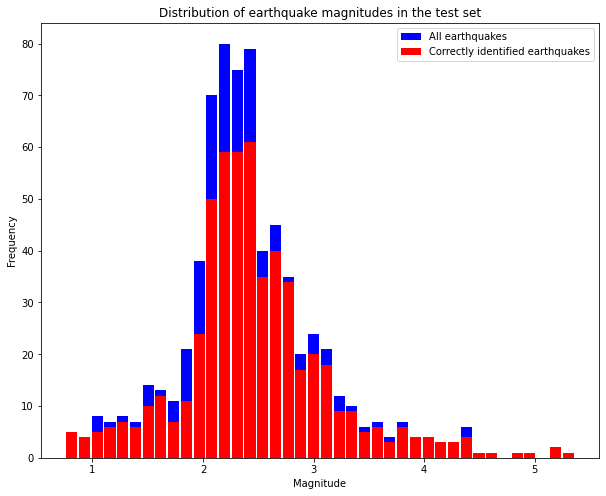

In [18]:
plot_unid_single(mapped_preds, test_ds, "magnitude", 2, 0, 0.1, broken = False)

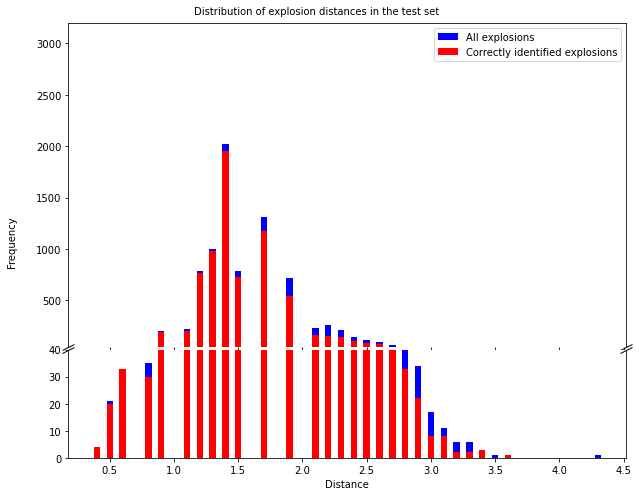

In [22]:
plot_unid_single(mapped_preds, test_ds, "magnitude", 1, 0, 0.05, broken = True)

0.3 4.3
Intercept:  0.0558710614159
Coef:  0.027398217553
P-value:  0.257894179146


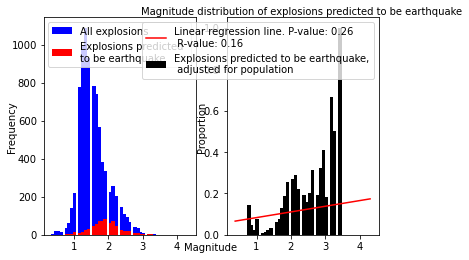

In [14]:
plot_error_both(pred_3n, pred_ee, test_ds, not_noise_indexes, "magnitude", 1, 2, 0.1)

0.7 5.3
Intercept:  0.214122954626
Coef:  -0.0445221083187
P-value:  0.000102888884331


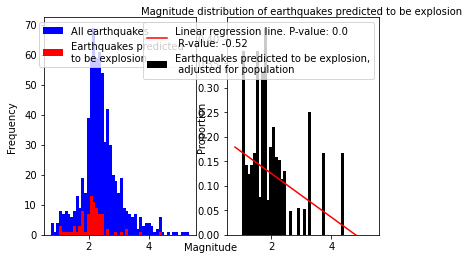

In [15]:
plot_error_both(pred_3n, pred_ee, test_ds, not_noise_indexes, "magnitude", 2, 1, 0.1)

# What am i trying to do:

 - Want to find out if the magnitude of the event is an important aspect of the classification decision.

## How:

 - Look at the distribution of magnitudes of explosion events classified as earthquakes
 - Look at the distribution of magnitudes of earthquake events classified as explosions
 
Compare these to the true distribution, maybe adjust for population to establish relationship
 

In [112]:
_, info = handler.path_to_trace("/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-08-25T16.23.00.603000Z.h5")
pp.pprint(info)

{'analyst_pick_time': None,
 'az_to_arces': 53.84368194360224,
 'baz_to_arces': 274.08992397241065,
 'dist_to_arces': 1932.3212602551716,
 'est_arrivaltime_arces': '2014-08-25 16:24:00.603000',
 'event_type': 'earthquake',
 'event_type_certainty': 'known',
 'magnitude_dist_ratio': 0.0022470383622579504,
 'magnitude_sqrtdist_ratio': 0.0987757083949491,
 'magnitudes': [{'mag': 4.342,
                 'magnitude_type': 'Mb',
                 'origin_id': 'smi:local/c83bdfb8-5122-486f-9a24-4e80fce8771b',
                 'resource_id': 'smi:local/18bf12f4-eb57-4f0a-b388-cf93e369df2d'},
                {'mag': -9.99,
                 'magnitude_type': 'Ml',
                 'origin_id': 'smi:local/c83bdfb8-5122-486f-9a24-4e80fce8771b',
                 'resource_id': 'smi:local/a535bb3c-ab42-4153-9e76-9c72626cf991'}],
 'origins': [{'arrivals': [{'azimuth': 326.97502,
                            'backazimuth_residual': -999.0,
                            'comments': [{'resource_id': 'smi:loc

In [52]:
noise_earth = get_noise_predicted_earthquake(mapped_preds, test_ds)

In [181]:
np.rint(0.5)

0.0

In [13]:
len(pred_ee), len(pred_3n)

(8998, 17642)

In [17]:
import pprint
pp = pprint.PrettyPrinter(indent=1)
j = 0

[ '/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2005-03-27T18.07.02.000000Z.h5'
 'noise' 0]
{'3n_pred': 0.99557692, 'ee_pred': 0.99620795, 'test_ds_index': 13403, 'not_noise_index': 6843, 'true_label': 'noise', 'predicted_label': 'earthquake'}


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


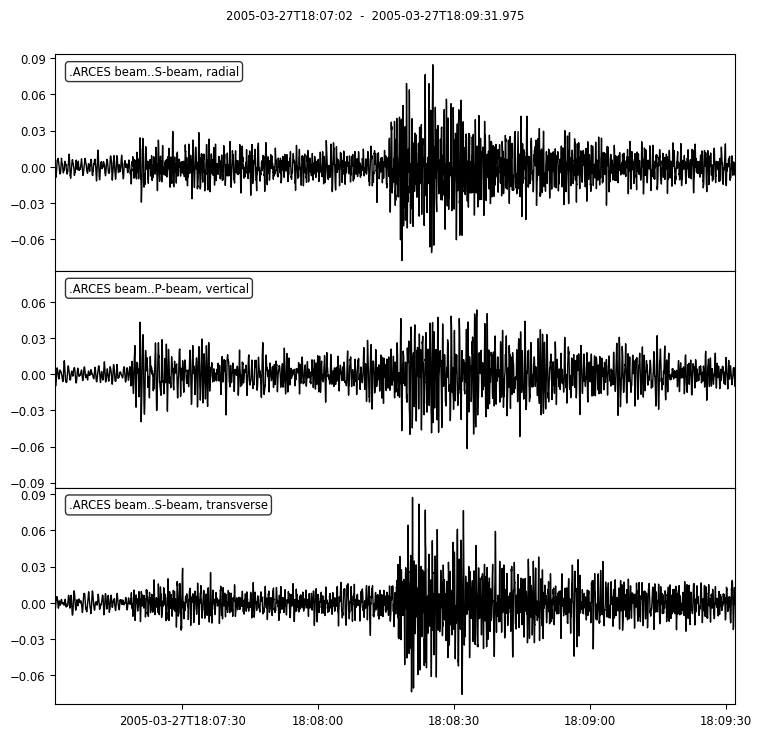

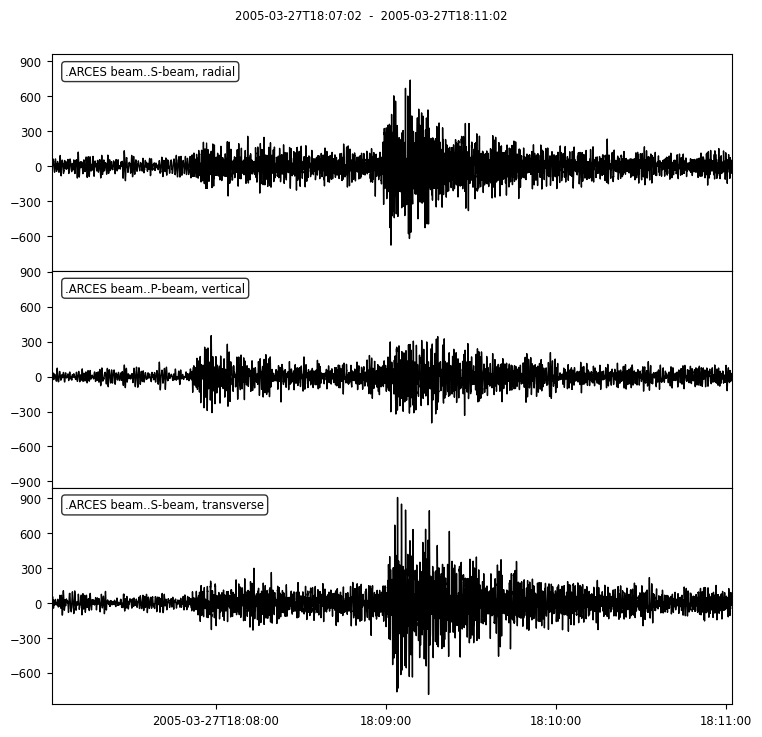

{'analyst_pick_time': None,
 'baz_to_arces': 5.474434495099191,
 'est_arrivaltime_arces': '2005-03-27 18:08:02',
 'trace_stats': {'channels': ['P-beam, vertical',
                              'S-beam, transverse',
                              'S-beam, radial'],
                 'sampling_rate': 40.0,
                 'starttime': '2005-03-27T18:07:02.000000Z',
                 'station': 'ARCES beam'}}


In [76]:
# Plotting false negative
event_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/noise/2005-03-27T18.07.02.000000Z.h5'
test_ds_index = noise_earth[event_path]['test_ds_index']
not_noise_index = noise_earth[event_path]['not_noise_index']
original_trace, sample_info = handler.path_to_trace(test_ds[test_ds_index][0])
print(test_ds[test_ds_index])

transformed_trace = x_test[test_ds_index]
print(noise_earth[event_path])
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp.pprint(sample_info)

Completed 3N predictions after f18 seconds. Amount of predictions: 17642
Average time per datapoint: 0.001007093524813936
Completed 3N predictions after f23 seconds. Amount of predictions: 17642
Average time per datapoint: 0.0013075673570709695
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
[['noise']
 ['noise']
 ['noise']
 ..., 
 ['not_noise']
 ['not_noise']
 ['noise']]
Prediction of 17642 complete. Process took 41 seconds
Average time per datapoint: 0.0023252103972253905
Plotting errors
Distances:
Max dist: 1852.0
Min dist: 86.0
Max dist: 1965.0
Min dist: 86.0


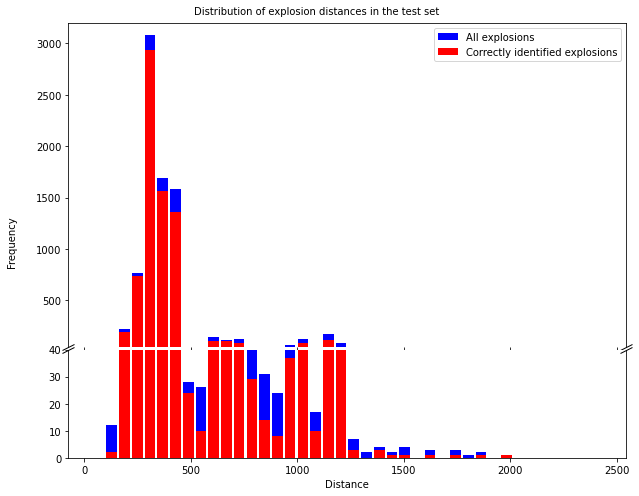

Max dist: 2394.0
Min dist: 137.0
Max dist: 2394.0
Min dist: 11.0


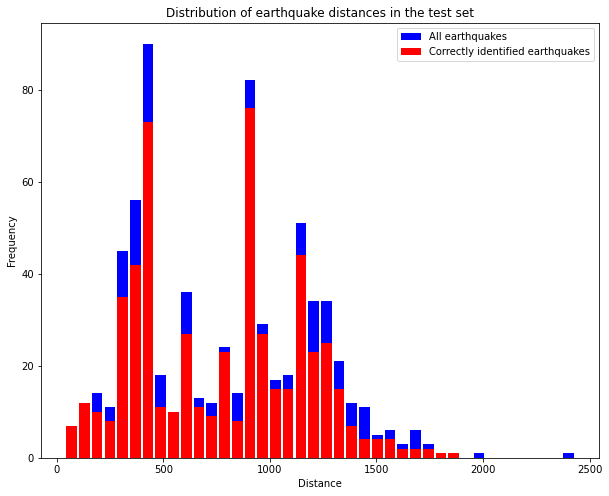

Magnitudes:
Max dist: 4.3
Min dist: 0.7
Max dist: 4.3
Min dist: 0.7


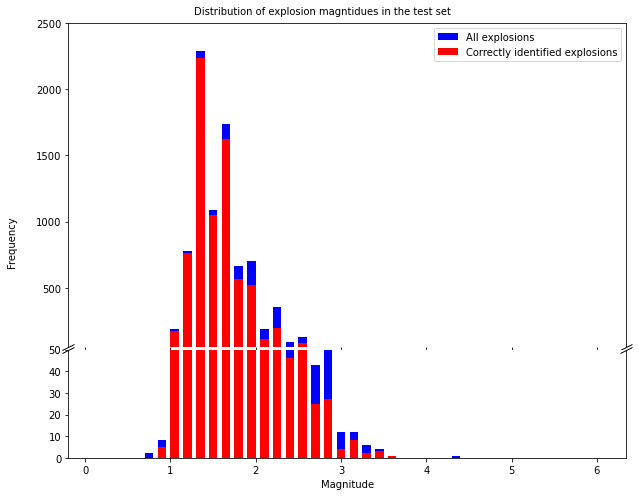

Max dist: 5.601
Min dist: 1.0
Max dist: 5.601
Min dist: 0.7


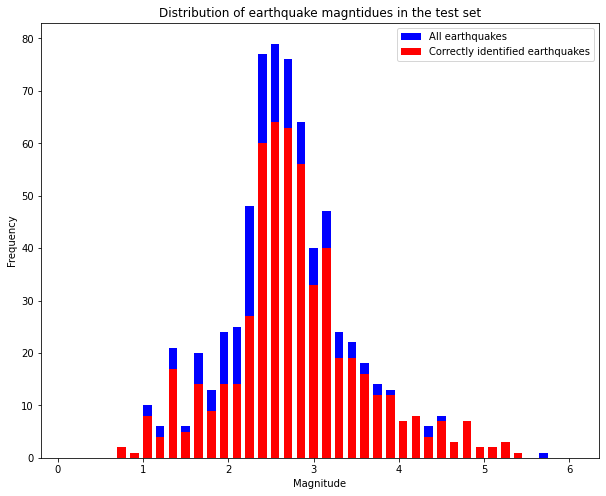

MSRDR:
Max dist: 0.2204338987563581
Min dist: 0.060004438309835983
Max dist: 0.248623046072668
Min dist: 0.06000339438365045


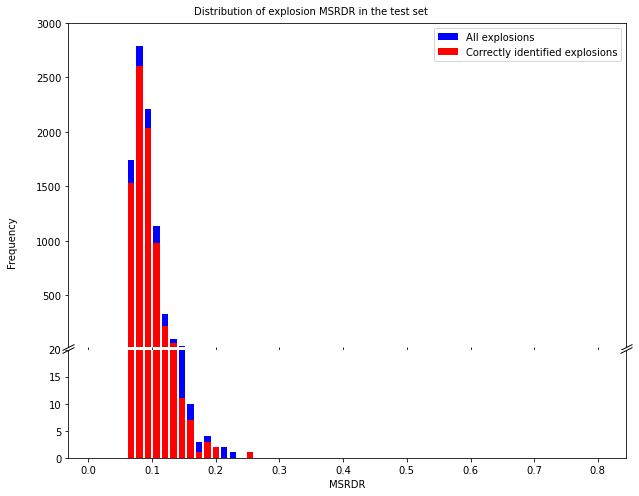

Max dist: 0.22025937986007593
Min dist: 0.06073591348988495
Max dist: 0.789717329282861
Min dist: 0.06039273726920308


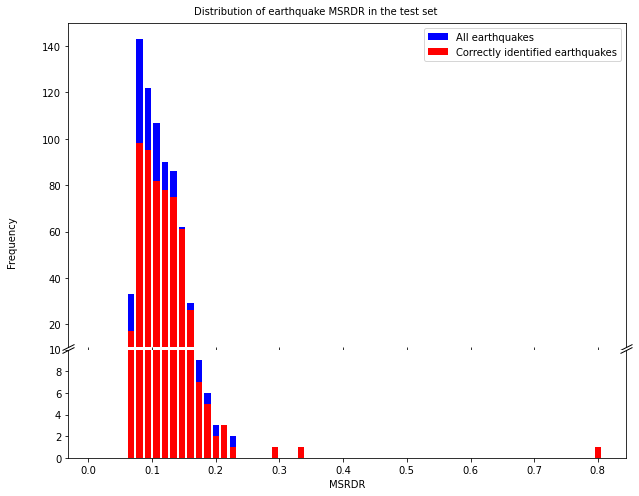

Finished
Plotting events incorrectly labeled noise:
Distances:
[0 0 0 ..., 1 1 0]
Max dist: 1852.0
Min dist: 176.0
Max dist: 1965.0
Min dist: 86.0
Intercept:  0.100924789365
Coef:  1.21747828584e-05
P-value:  0.803107694741


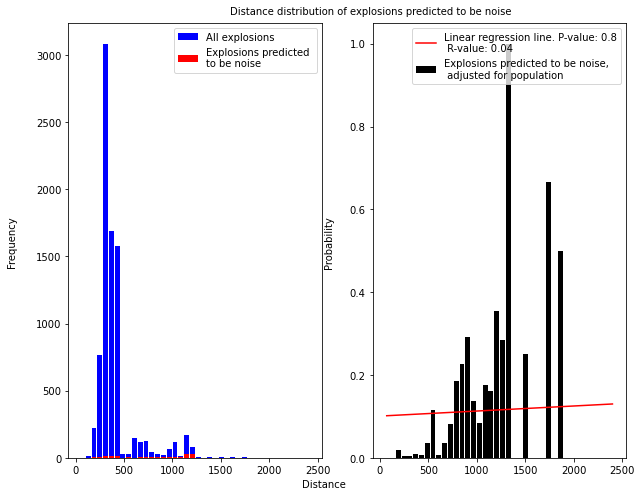

[0 0 0 ..., 1 1 0]
Max dist: 2394.0
Min dist: 139.0
Max dist: 2394.0
Min dist: 11.0
Intercept:  0.00726640616643
Coef:  8.49530280906e-05
P-value:  0.0697704501882


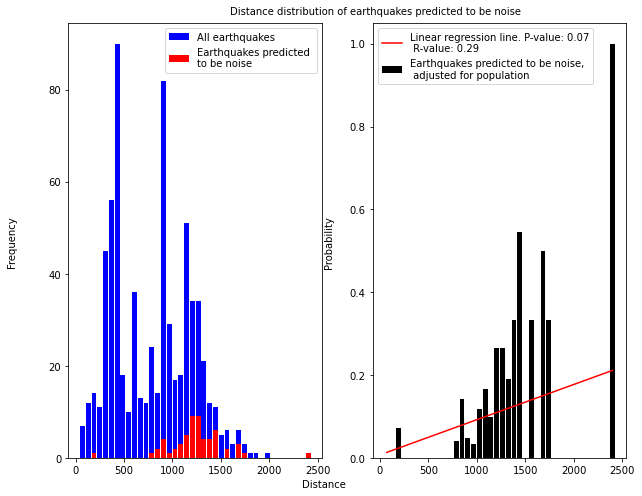

Magnitudes:
[0 0 0 ..., 1 1 0]
Max dist: 4.3
Min dist: 0.9
Max dist: 4.3
Min dist: 0.7
Intercept:  0.0264386960172
Coef:  0.00623632784428
P-value:  0.67717215514


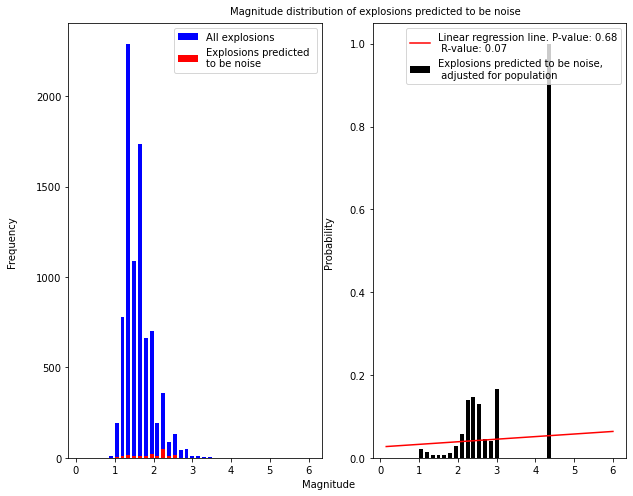

[0 0 0 ..., 1 1 0]
Max dist: 4.302
Min dist: 1.882
Max dist: 5.601
Min dist: 0.7
Intercept:  0.0382547858533
Coef:  0.000323815943025
P-value:  0.950193207721


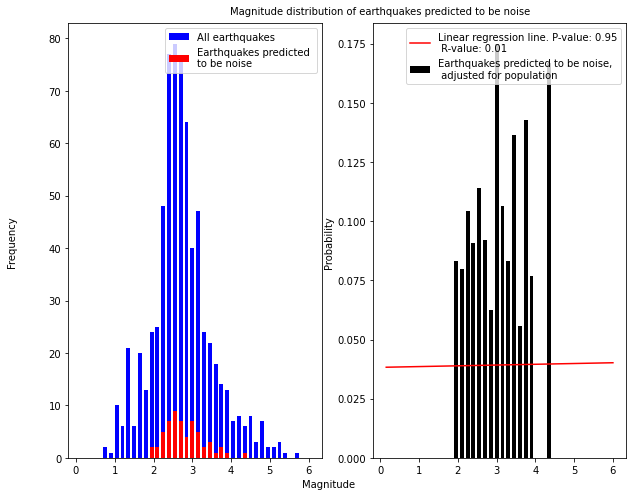

MSRDR:
[0 0 0 ..., 1 1 0]
Max dist: 0.14095092201657328
Min dist: 0.060004438309835983
Max dist: 0.248623046072668
Min dist: 0.06000339438365045
Intercept:  0.00747566246562
Coef:  -0.0129317092312
P-value:  0.0071472403714


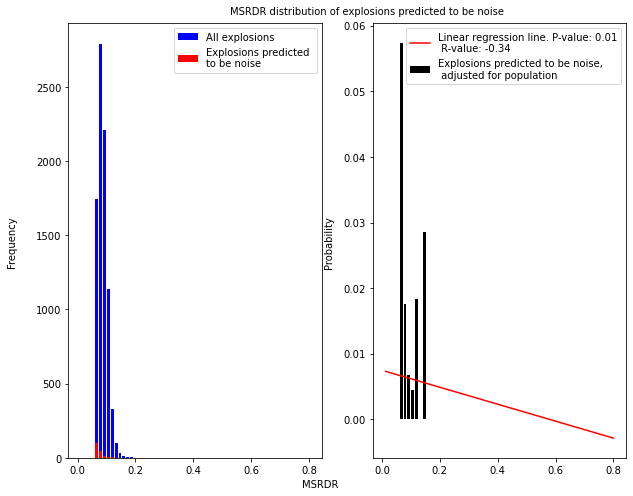

[0 0 0 ..., 1 1 0]
Max dist: 0.22025937986007593
Min dist: 0.06073591348988495
Max dist: 0.789717329282861
Min dist: 0.06039273726920308
Intercept:  0.0585998102035
Coef:  -0.0963094895872
P-value:  0.0288425241499


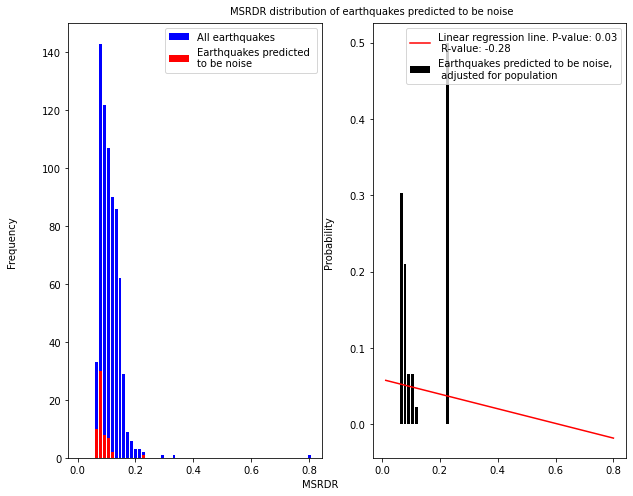

tf.Tensor(
[[8407   65  107]
 [ 176 7452  737]
 [  58   87  553]], shape=(3, 3), dtype=int32)
              precision    recall  f1-score   support

       noise       0.97      0.98      0.98      8579
   explosion       0.98      0.89      0.93      8365
  earthquake       0.40      0.79      0.53       698

    accuracy                           0.93     17642
   macro avg       0.78      0.89      0.81     17642
weighted avg       0.95      0.93      0.94     17642

['noise', 'explosion', 'earthquake']


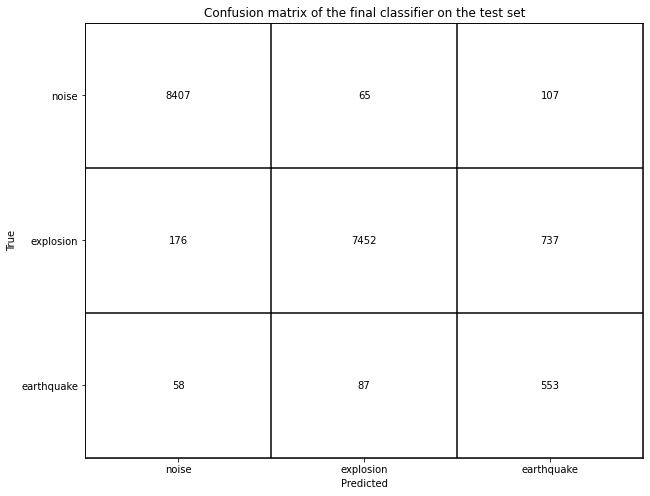

In [11]:
test_pred = predict_final_model(loadData, model_3n, model_ee, x_test, y_test, noiseAug, 3, 3)

conf, report, precision, recall, fscore  = evaluate_full_pipeline(test_pred, x_test, y_test, test_ds)

print(conf)
print(report)
plot_confusion_matrix(conf,{"noise" : 0, "explosion" : 1, "earthquake" : 2})

In [ ]:
plot_all_plots(test_pred, y_test, test_ds)


In [ ]:
conf

In [ ]:
print(report)

In [ ]:
fscore

In [ ]:
precision

In [ ]:
plot_confusion_matrix(conf,{"noise" : 0, "explosion" : 1, "earthquake" : 2})

Recall for noise: 0.9799510432
precision for noise: 0.9729198009
f2 for noise: 0.978536676165186

Recall for explosions:  7452 / 8365   0.890854751943
Precision for explosions: 0.9800105208
f2 for explo: 0.9073641145568898

Recall for earthquakes: 0.7922636103
Precision for earth: 0.3958482462

In [ ]:
def f2_score(recall, precision):
    return ((1+2**2)*precision*recall)/((2**2)*precision+recall)

In [ ]:
f2_n = f2_score(0.7922636103, 0.3958482462)
f2_n

In [ ]:
print(len(test_pred))

In [ ]:
print(len(y_test))

In [ ]:
def get_all_errors(preds, true):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_true = transform_true_labels(true, final_dict)
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    assert len(final_true) == len(final_preds)
    error_indexes = []
    for i in range(len(final_true)):
        if final_true[i] != final_preds[i]:
            error_indexes.append(i)
    return error_indexes
        
    

In [ ]:
error_indexes = get_all_errors(test_pred, y_test)

In [ ]:
len(error_indexes)

In [ ]:
test_errors = test_ds[error_indexes]

In [ ]:
def get_all_unidentified_by_type(type_int, predictions, y_test):
    index_list = []
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    final_true = transform_true_labels(y_test, final_dict)
    for i in range(len(final_true)):
        if final_true[i] == type_int and final_true[i] != final_preds[i]:
            print(predictions[i])
            index_list.append(i)
    return index_list
            

In [ ]:
unidentified_earthquake_indexes = get_all_unidentified_by_type(2, test_pred, y_test)

In [ ]:
len(unidentified_earthquake_indexes)

In [ ]:
unid_earthquake = test_ds[unidentified_earthquake_indexes]

In [ ]:
unid_earthquake

In [ ]:
len(eq_noise)

In [ ]:
plot_msrdr_unid(test_pred, y_test, test_ds, 1)

In [ ]:
plot_magnitude_unid(test_pred, y_test, test_ds, 1)

In [ ]:
plot_distances_unid(test_pred, y_test, test_ds, 1)

In [ ]:
unid_earth_dist = get_distance_distribution(unid_earthquake)
all_earth_dist = get_distance_distribution(test_ds[test_ds[:,1] == "earthquake"])



In [ ]:
nr_bins = 40
bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_earth_dist, nr_bins, 10, 2400)
bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_earth_dist, nr_bins, 10, 2400)
counts_u = counts_o - counts_u

plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, "Distribution of earthquake distances in the test set", "Distance", "Frequency")

In [ ]:
def get_class_incorrectly_predicted_noise(test_pred, y_true, type_int):
    index_list = []
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    final_preds = np.array([final_dict.get(x[0]) for x in test_pred])
    print(final_preds)
    final_true = transform_true_labels(y_test, final_dict)
    for i in range(len(test_pred)):
        if final_preds[i] == 0 and final_true[i] == type_int:
            index_list.append(i)
    return index_list

In [ ]:
eq_noise = get_class_incorrectly_predicted_noise(test_pred, y_test, 2)
print(len(eq_noise))

In [ ]:
from scipy.stats import linregress

def plot_distances_noise(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    
    if type_int == 1:
        low_max = 40
        high_max = 3200
        broken_plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, low_max, high_max, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")
    else:
    
        plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

def plot_distances_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Distance distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Distance"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
        #plot_unidentified_and_original(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, 50, type_int, f"Distribution of {key_list[type_int]} distances in the test set", "Distance", "Frequency")

        
def plot_magnitude_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_magnitude_distribution(unid)
    all_dist = get_magnitude_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 6)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 6)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Magnitude distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Magnitude"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 0.1, type_int, title, xlabel, ylabel)
    
def plot_distance_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_distance_distribution(unid)
    all_dist = get_distance_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 10, 2400)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 10, 2400)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Distance distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Distance"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 50, type_int, title, xlabel, ylabel)
    
def plot_magnitude_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_magnitude_distribution(unid)
    all_dist = get_magnitude_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 6)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 6)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"Magnitude distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "Magnitude"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 0.1, type_int, title, xlabel, ylabel)

    
def plot_msrdr_noise_both(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_msrdr_distribution(unid)
    all_dist = get_msrdr_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 60

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 0.8)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 0.8)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"MSRDR distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "MSRDR"
    ylabel = "Probability"
    #plot_adjusted(pdf, bins_count, counts, 50, type_int, title, xlabel, ylabel)
    plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts, 0.01, type_int, title, xlabel, ylabel)

    
    
def plot_msrdr_noise_adjusted(predictions, y_test, test_ds, type_int):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    unid = get_class_incorrectly_predicted_noise(predictions, y_test, type_int)
    unid = test_ds[unid]
    unid_dist = get_msrdr_distribution(unid)
    all_dist = get_msrdr_distribution(test_ds[test_ds[:,1] == f"{key_list[type_int]}"])
    nr_bins = 40

    bins_count_u, counts_u, pdf_u, _ = get_bins_count_pdf_cdf(unid_dist, nr_bins, 0, 0.8)
    bins_count_o, counts_o, pdf_o, _ = get_bins_count_pdf_cdf(all_dist, nr_bins, 0, 0.8)
    pdf = pdf_u
    bins_count = bins_count_u
    counts = adjust_by_pop(counts_o, counts_u)
    title = f"MSRDR distribution of {key_list[type_int]}s predicted to be noise"
    xlabel = "MSRDR"
    ylabel = "Probability"
    plot_adjusted(pdf, bins_count, counts, 0.01, type_int, title, xlabel, ylabel)


def plot_adjusted(pdf, bins_count, counts, width, type_int, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    plt.bar(bins_count[1:], counts, width=width, color="red", label=f"E{key_list[type_int][1:]}s predicted to be noise, adjusted for population")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()

def plot_both(pdf_o, pdf_u, bins_count_o, bins_count_u, counts_o, counts_u, counts_a, width, type_int, title, xlabel, ylabel):
    final_dict = {"noise" : 0, "explosion" : 1, "earthquake" : 2}
    key_list = list(final_dict.keys())
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.subplots_adjust(hspace=0.1)
    ax1.bar(bins_count_o[1:], counts_o, width=width, color="blue", label=f"All {key_list[type_int]}s")
    ax1.bar(bins_count_u[1:], counts_u, width=width, color="red", label=f"E{key_list[type_int][1:]}s predicted \nto be noise")
    
    slope, intercept, r_value, p_value, std_err  = linregress(bins_count_u[1:], counts_a)
    
    ax2.plot(bins_count_u[1:], slope*bins_count_u[1:]+intercept, color = "red", label = f"Linear regression line. P-value: {round(p_value, 2)}\n R-value: {round(r_value, 2)}")
    print("Intercept: ", intercept)
    print("Coef: ", slope)
    print("P-value: ", p_value)
    
    #coef = np.polyfit(bins_count_u[1:], counts_a,1)
    #poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y

    #plt.plot(bins_count_u[1:], counts_a, 'yo', bins_count_u[1:], poly1d_fn(bins_count_u[1:]), '--k', color = "black")
    #plt.plot(bins_count_u[1:], counts_a, 'yo', bins_count_u[1:], poly1d_fn(bins_count_u[1:]), '--k', color = "black")
    ax2.bar(bins_count_u[1:], counts_a, width=width, color="black", label=f"E{key_list[type_int][1:]}s predicted to be noise,\n adjusted for population")
    
    
    fig.text(0.45, 0.08, xlabel, va='center')
    fig.text(0.04, 0.5, "Frequency", va='center', rotation='vertical')
    fig.text(0.48, 0.5, "Probability", va='center', rotation = 'vertical')
    fig.text(0.35, 0.9, title, va = 'center')
    ax1.legend()
    ax2.legend()
    plt.show()
    


def adjust_by_pop(counts_o, counts_u):
    new_counts = []
    for i in range(len(counts_o)):
        if counts_u[i] == 0:
            new_counts.append(0)
        else:
            new_counts.append(counts_u[i]/counts_o[i])
    return new_counts

In [ ]:
plot_msrdr_noise_both(test_pred, y_test, test_ds, 2)

# Distances
- Want to portray how the distance of the event correlates to its error.
- Look at errors of earthquakes and explosions and plot their distance.
- MSRDR could be interesting, portraying signal to noise ratio.
- 


Looking at distance errors:
- For both earthquakes and explosions (seperately):
 - could look at errors adjusted for frequency

In [ ]:
# Of the events which are predicted to be noise, how do they identify in terms of magnitude, distance and msrdr?
# Need for each non-noise class: The events predicted to be noise in error.